In [40]:
# Setup
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot
import statsmodels
import statsmodels.tsa.stattools as tsa
from arch import arch_model

In [7]:
# A demonstration of capabilities

msft = yf.Ticker("MSFT")

# get stock info
msft.info

# get historical market data
hist = msft.history(period="max")

# show actions (dividends, splits)
msft.actions

# show dividends
msft.dividends

# show splits
msft.splits

# show financials
msft.financials
msft.quarterly_financials

# show major holders
msft.major_holders

# show institutional holders
msft.institutional_holders

# show balance sheet
msft.balance_sheet
msft.quarterly_balance_sheet

# show cashflow
msft.cashflow
msft.quarterly_cashflow

# show earnings
msft.earnings
msft.quarterly_earnings

# show sustainability
msft.sustainability

# show analysts recommendations
msft.recommendations

# show next event (earnings, etc)
msft.calendar

# show ISIN code - *experimental*
# ISIN = International Securities Identification Number
msft.isin

# show options expirations
msft.options

# get option chain for specific expiration
opt = msft.option_chain('2020-12-17')
# data available via: opt.calls, opt.puts

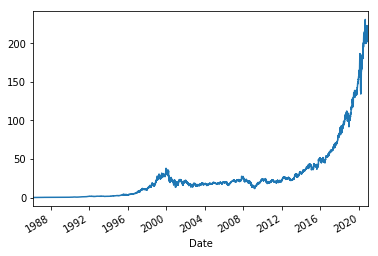

In [19]:
temp_data = hist['Close']

temp_data.plot()
pyplot.show()

It should be clear that this data is not stationary - the mean is certainly not constant, nor is the variance.
We run the Augmented Dickey-Fuller (ADF) Test to verify.

In [26]:
tsa.adfuller(temp_data, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(8.098423580543738,
 1.0,
 36,
 8726,
 {'1%': -3.4310996246527132,
  '5%': -2.8618712841785983,
  '10%': -2.566946337601596},
 22905.388534435362)

As evidenced by the second data point, we have a p-value of 1.0, indicating to us that this data is not stationary.
We now attempt to turn this dataset into a stationary one.

A good interpretation of the results of the adfuller test can be found here:
https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results

In [33]:
msft_diff = [x - temp_data[i - 1] for i, x in enumerate(temp_data)][1:]

C:\Users\savio\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


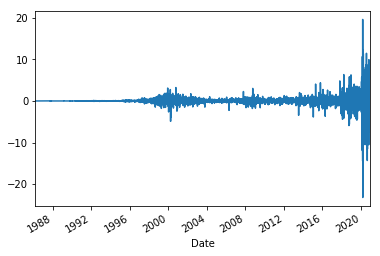

In [36]:
# We now plot out the difference
rem_one = hist.iloc[1:]
rem_one['Diff'] = msft_diff
rem_one['Diff'].plot()
pyplot.show()

It now appears that the mean is stationary, but the variance certainly is not. 
Let us run the ADF test again.

In [38]:
tsa.adfuller(rem_one['Diff'], maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(-15.634808564470234,
 1.668120859218079e-28,
 37,
 8724,
 {'1%': -3.431099796556747,
  '5%': -2.861871360139148,
  '10%': -2.5669463780359156},
 22951.621786311895)

This time, according to the ADF test, this difference'd dataset is stationary.
Now we must consider what model we should apply to this.
Given that there exist several instances of large spikes in volatility, a GARCH(1,1) model seems useful.

In [42]:
garch11 = arch_model(rem_one['Diff'], p=1, q=1)
res = garch11.fit(update_freq=10)
print(res.summary())

Iteration:     10,   Func. Count:     88,   Neg. LLF: -1275.0492788317247
Iteration:     20,   Func. Count:    166,   Neg. LLF: -2323.5892088870687
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2317.477469155778
            Iterations: 27
            Function evaluations: 218
            Gradient evaluations: 26
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   Diff   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                2317.48
Distribution:                  Normal   AIC:                          -4626.95
Method:            Maximum Likelihood   BIC:                          -4598.64
                                        No. Observations:                 8762
Date:                Tue, Dec 15 2020   Df Residuals:                     8758
Time:   

In [54]:
# Forecast
forecasts = res.forecast(horizon=5)
print(forecasts.mean.iloc[-3:])
print(forecasts.residual_variance.iloc[-3:])
print(forecasts.variance.iloc[-3:])

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2020-12-11       NaN       NaN       NaN       NaN       NaN
2020-12-14       NaN       NaN       NaN       NaN       NaN
2020-12-15  0.000567  0.000567  0.000567  0.000567  0.000567
                  h.1        h.2        h.3        h.4        h.5
Date                                                             
2020-12-11        NaN        NaN        NaN        NaN        NaN
2020-12-14        NaN        NaN        NaN        NaN        NaN
2020-12-15  10.900867  10.900867  10.900867  10.900868  10.900868
                  h.1        h.2        h.3        h.4        h.5
Date                                                             
2020-12-11        NaN        NaN        NaN        NaN        NaN
2020-12-14        NaN        NaN        NaN        NaN        NaN
2020-12-15  10.900867  10.900867  10.900867  10.900868  10.900868
